# Autograd

In [1]:
import autograd
from autograd import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
ndim = 10

In [3]:
def x_init(ndim, seed=0):
    np.random.seed(seed)
    return np.random.rand(ndim)

In [4]:
def y(x):
    return np.sum(x**2)

def g_exact(x):
    return 2. * x

g_auto = autograd.grad(y)

In [5]:
from scipy.optimize import minimize

## With numerical gradient

In [6]:
r = minimize(y, x_init(ndim), method='BFGS')
print("minimum: {}".format(r.x))
print("nit={}  nfev={}  njev={}".format(r.nit, r.nfev, r.njev))

minimum: [  1.44079457e-08   1.07777187e-09  -2.37100333e-08   4.97857175e-09
  -1.07706796e-08  -4.38312052e-09  -1.55044568e-08  -1.17504437e-08
  -1.18699967e-08  -1.79687886e-08]
nit=2  nfev=48  njev=4


## With analytic gradient

In [7]:
r = minimize(y, x_init(ndim), jac=g_exact, method='BFGS')
print("minimum: {}".format(r.x))
print("nit={}  nfev={}  njev={}".format(r.nit, r.nfev, r.njev))

minimum: [ -4.25752641e-17  -1.59377719e-17  -2.36762649e-17   8.01631981e-18
   3.28716546e-17   6.41847686e-17  -3.87602277e-18   3.07642366e-17
  -3.52636757e-17  -6.43745040e-18]
nit=2  nfev=4  njev=4


## With automatic gradient

In [8]:
r = minimize(y, x_init(ndim), jac=g_auto, method='BFGS')
print("minimum: {}".format(r.x))
print("nit={}  nfev={}  njev={}".format(r.nit, r.nfev, r.njev))

minimum: [ -4.25752641e-17  -1.59377719e-17  -2.36762649e-17   8.01631981e-18
   3.28716546e-17   6.41847686e-17  -3.87602277e-18   3.07642366e-17
  -3.52636757e-17  -6.43745040e-18]
nit=2  nfev=4  njev=4


## Compare timing

In [9]:
print("time with numerical derivatives")
%timeit minimize(y, x_init(ndim), method='BFGS')
print("time with analytic derivatives")
%timeit minimize(y, x_init(ndim), jac=g_exact, method='BFGS')
print("time with autograd")
%timeit minimize(y, x_init(ndim), jac=g_auto, method='BFGS')

time with numerical derivatives
1000 loops, best of 3: 782 µs per loop
time with analytic derivatives
1000 loops, best of 3: 238 µs per loop
time with autograd
1000 loops, best of 3: 930 µs per loop


## Benchmarking

In [10]:
import time as wallclock

def analyze(g, ndims):
    niters = np.zeros_like(ndims)
    nfevs = np.zeros_like(ndims)
    times = np.zeros_like(ndims, dtype=np.float64)
    for i, ndim in enumerate(ndims):
        r = minimize(y, x_init(ndim), jac=g, method='BFGS')
        niters[i] = r.nit
        nfevs[i] = r.nfev
        t0 = wallclock.time()
        nloops = max(1, 2000 // ndim)
        for j in range(nloops):
            minimize(y, x_init(ndim), jac=g, method='BFGS')
        t1 = wallclock.time()
        times[i] = (t1 - t0) / nloops

    return {'niters': niters, 'nfevs': nfevs, 'times': times}

In [11]:
ndims = np.array([10, 100, 1000, 3000], dtype=np.int64)
results = {}
results['Numerical'] = analyze(None, ndims)
results['Analytic'] = analyze(g_exact, ndims)
results['AutoGrad'] = analyze(g_auto, ndims)

In [12]:
def plot(results, ordinate, ylabel, ylogscale=True):
    fig = plt.figure()
    for label in results:
        if ylogscale:
            plt.loglog(ndims, results[label][ordinate], label=label)
        else:
            plt.semilogx(ndims, results[label][ordinate], label=label)
            
    plt.xlabel('dimensions')
    plt.ylabel(ylabel)
    plt.legend(loc='upper left')
    plt.show()

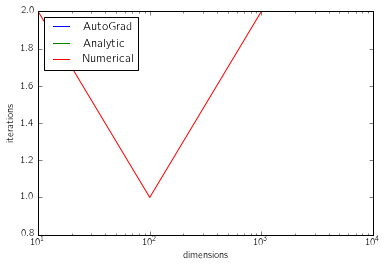

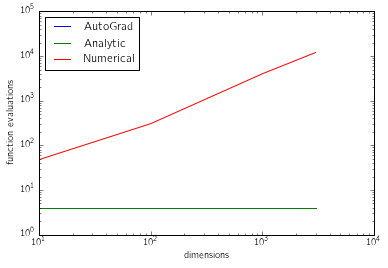

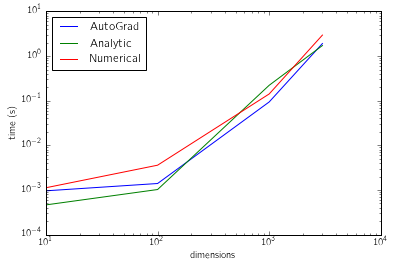

In [13]:
plot(results, 'niters', 'iterations', ylogscale=False)
plot(results, 'nfevs', 'function evaluations')
plot(results, 'times', 'time (s)')

# Theano

In [14]:
import theano
import theano.tensor as T

x_ = T.dvector('x')
y_ = T.sum(x_ ** 2)
g_ = T.grad(y_, x_)
g_theano = theano.function([x_], g_)

In [15]:
print("time with Theano")
%timeit minimize(y, x_init(ndim), jac=g_theano, method='BFGS')

time with Theano
The slowest run took 6.08 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 329 µs per loop


In [16]:
results['Theano'] = analyze(g_theano, ndims)

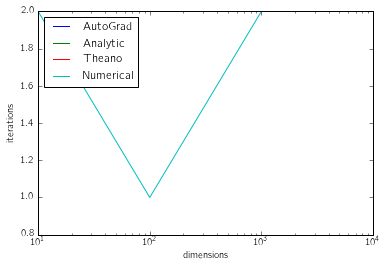

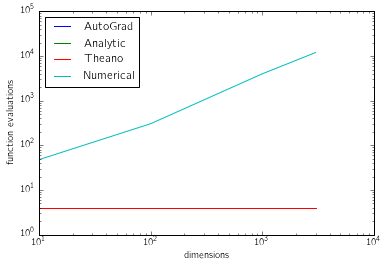

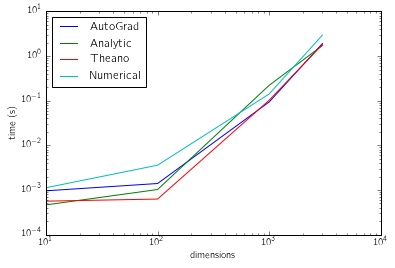

In [17]:
plot(results, 'niters', 'iterations', ylogscale=False)
plot(results, 'nfevs', 'function evaluations')
plot(results, 'times', 'time (s)')

# Tensorflow

In [14]:
import tensorflow as tf

In [15]:
tol = 1e-9
maxiter = 1000

In [16]:
x = tf.Variable(np.array([3.]))
y = x**2

In [17]:
print(x)

In [18]:
optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(y)

# Before starting, initialize the variables.  We will 'run' this first.
init = tf.initialize_all_variables()
# Launch the graph.
with tf.Session() as sess:
    sess.run(init)
    # Fit the line.
    step = 0
    while abs(sess.run(x)) > tol and step < maxiter:
        step += 1
        if step % 20 == 0:
            print(step, sess.run(x), sess.run(y))
        sess.run(train)
        
    print("Minimum found after {} steps: x={}, y={}".format(step, sess.run(x), sess.run(y)))

Minimum found after 1 steps: x=[ 0.], y=[ 0.]
